# Developing an Age Verification Model for Alcohol Sales Compliance

**Introduction**


Good Seed supermarket chain aims to enhance compliance with alcohol sales regulations by preventing underage alcohol purchases. To achieve this, the project explores the use of computer vision techniques to estimate customers' ages from facial images captured at checkout. By developing an accurate age prediction model, the solution can support staff in ensuring regulatory adherence while improving operational efficiency. This project involves analyzing the dataset, building a machine learning model, and evaluating its effectiveness in addressing this critical business challenge.

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING logs


## EDA

## Loading and Exploring Labels

In [2]:

# Load labels
path = '/datasets/faces/'  # Adjust path as needed
labels = pd.read_csv(f"{path}/labels.csv")

# Display first few rows
print(labels.head())

# Check for missing values
print(labels.isnull().sum())

# Check the data types
print(labels.info())


    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
file_name    0
real_age     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


**Observations:**

Dataset Size: Contains 7,591 images with corresponding ages.

No Missing Data: Both columns (file_name and real_age) are fully populated.

Data Types: file_name is a string, and real_age is an integer.

### Analyze the Target Variable (real_age)

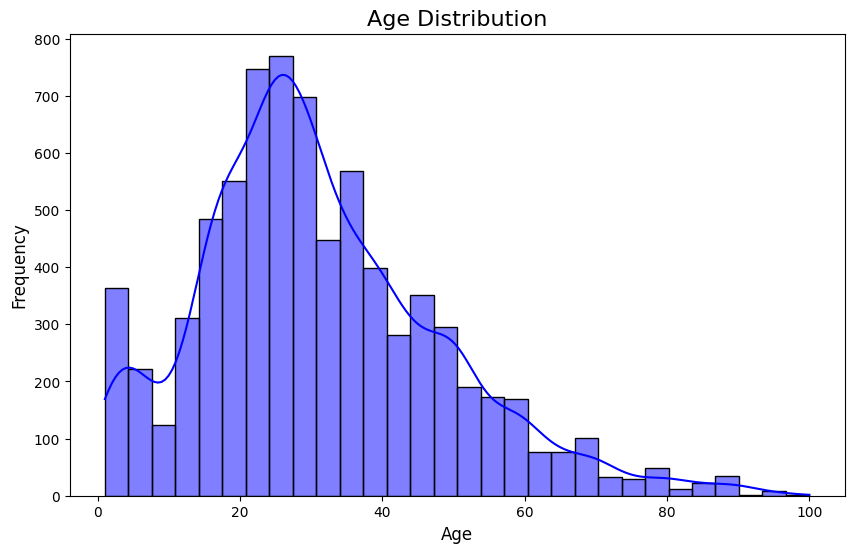

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [3]:
# Plot distribution of ages
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Summary statistics
print(labels['real_age'].describe())


**Observations:**
    
    
The age distribution is right-skewed, with more younger individuals than older ones.

Most frequent age group: 20–40 years (as indicated by the peak in the histogram).

Some tail values extend to extreme ages (e.g., 100 years), indicating outliers or rare occurrences of very old individuals.


**Key Observations**

Skewed Distribution:

The right skew suggests fewer older individuals than younger ones.
This might affect model performance, especially if the model underperforms for underrepresented age groups (e.g., elderly).


High Variance:

The wide range of ages and high standard deviation indicate diversity in the dataset, which is beneficial for model generalization.


Potential Outliers:

Ages close to 1 year and 100 years could be outliers. It's worth checking these images for validity (e.g., mislabels or noise).


Implications for Modeling:

Since this is a regression task, the model should account for:


Non-uniform age distribution: Using metrics like MAE can help mitigate the impact of underrepresented groups.


Outliers: If outliers are deemed invalid, removing them might improve training stability.

### Check Class Balance

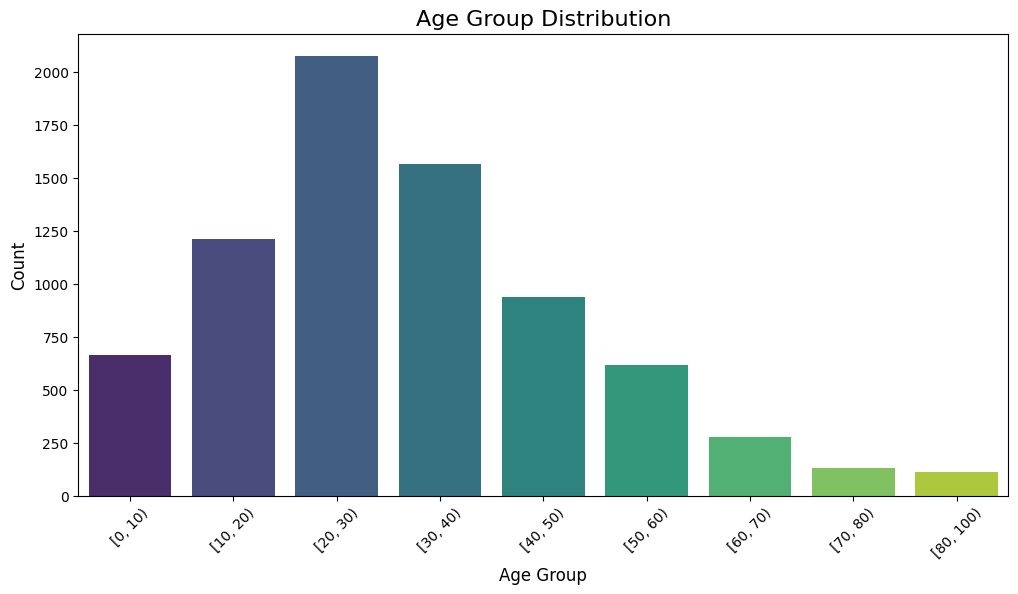

In [4]:
# Create age bins for visualization
labels['age_group'] = pd.cut(labels['real_age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 100], right=False)

# Plot counts of age groups
plt.figure(figsize=(12, 6))
sns.countplot(x='age_group', data=labels, palette='viridis')
plt.title('Age Group Distribution', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


**Observations:**
    
The graph illustrates the distribution of different age groups. 

The highest count is seen in the 20-30 age group, followed by the 30-40 age group.

The count decreases as age increases, with the lowest count being in the 80-100 age group. 

The graph's x-axis represents the age groups, while the y-axis represents the count for each group.

### Visualize Sample Images

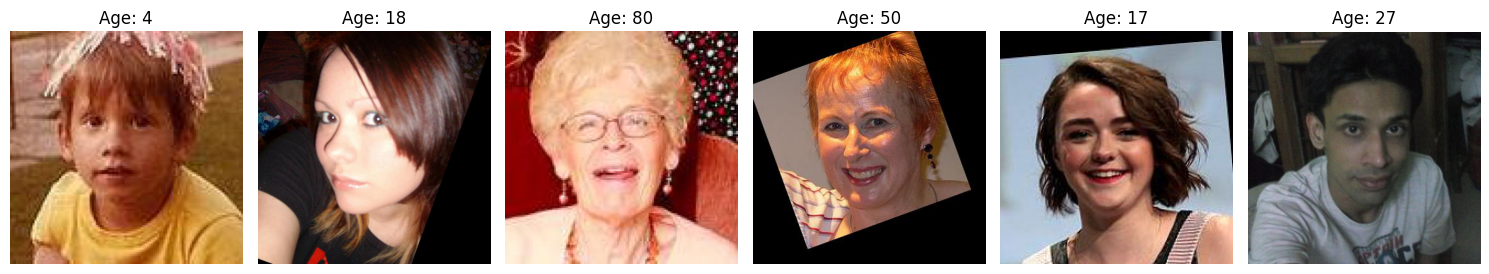

In [5]:

# Display sample images using PIL
def plot_sample_images(labels, path, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 8))
    for i, ax in enumerate(axes):
        file_name = labels.iloc[i]['file_name']
        age = labels.iloc[i]['real_age']
        image_path = os.path.join(path, 'final_files', file_name)
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title(f"Age: {age}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_sample_images(labels, path)


## Check Image Sizes

             Width       Height
count   100.000000   100.000000
mean    472.380000   471.730000
std     387.325426   387.878192
min      69.000000    69.000000
25%     210.000000   209.750000
50%     354.500000   354.500000
75%     618.250000   618.500000
max    2364.000000  2364.000000


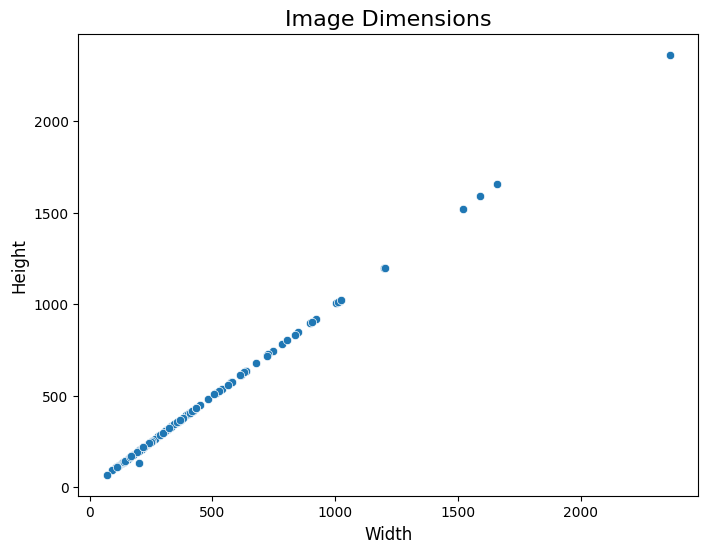

In [6]:

image_shapes = []

for file_name in labels['file_name'].head(100):  # Sample first 100 images
    image_path = os.path.join(path, 'final_files', file_name)
    with Image.open(image_path) as img:
        image_shapes.append(img.size)

# Analyze image sizes
image_shapes_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
print(image_shapes_df.describe())

# Plot image sizes
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Width', y='Height', data=image_shapes_df)
plt.title('Image Dimensions', fontsize=16)
plt.xlabel('Width', fontsize=12)
plt.ylabel('Height', fontsize=12)
plt.show()



**Image Size Analysis**
 
Dimensions:

A sample of 100 images shows varying sizes.

Mean width/height: ~472 pixels.

Minimum size: 69x69 pixels.

Maximum size: 2364x2364 pixels.


Visualization:

Scatterplot of width vs. height indicates:

Most images are roughly square.

Some outliers have large dimensions, which might affect model training.


Implications:

Images will be resized to 224x224 for the model.

Dataset Insights:

Imbalance: Age distribution is uneven, favoring younger individuals.

Diversity: Wide range of image dimensions and ages.

Outliers: Extreme ages and image sizes may need closer inspection.


##  Identify Missing or Corrupted Images

In [7]:
missing_files = []

for file_name in labels['file_name']:
    image_path = os.path.join(path, 'final_files', file_name)
    if not os.path.exists(image_path):
        missing_files.append(file_name)

print(f"Number of missing files: {len(missing_files)}")
if missing_files:
    print("Sample missing files:", missing_files[:5])


Number of missing files: 0


The dataset is complete; all image files referenced in the labels are present.

No additional action is needed to handle missing or corrupted files at this stage.

## Modelling

## Defining the load_train Function

In [8]:
path = "/datasets/faces/"

def load_train(path):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f"{path}/labels.csv"),
        directory=f"{path}/final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="training",
        seed=12345
    )
    return train_gen_flow


Purpose: 

Prepares the training data generator for image augmentation and loading images in batches.

Steps:


ImageDataGenerator: Rescales pixel values to the range [0, 1] (original range is [0, 255]) and splits the data (75% training, 25% validation).
flow_from_dataframe: Reads image file names and labels from the CSV file, maps them to image files, resizes images to 224x224, and loads them into memory in batches of 32.
subset="training": Ensures only the training set is loaded.

## Defining the load_test Function

In [9]:
def load_test(path):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f"{path}/labels.csv"),
        directory=f"{path}/final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="validation",
        seed=12345
    )
    return test_gen_flow


Purpose: 

Prepares the validation/test data generator.


Steps: 

Similar to load_train but uses subset="validation".

Observations:
Allows evaluation on unseen data (validation split).
Ensures the same scaling and preprocessing as the training data.


## Defining the create_model Function

In [10]:
def create_model(input_shape=(224, 224, 3)):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="mse",
                  metrics=["mae"])
    return model


Purpose: 
Defines a regression model based on the ResNet50 architecture.

Steps:

Base Model: Loads pre-trained ResNet50 as a feature extractor (imagenet weights, top layers removed).

Global Average Pooling: Reduces spatial dimensions to a vector.

Dropout: Adds regularization to prevent overfitting.

Dense Layer: Outputs a single value (age prediction) using a linear activation.

Compile: Specifies the optimizer (Adam), loss function (Mean Squared Error), and metric (Mean Absolute Error).

##  Defining the train_model Function

In [11]:
def train_model(model, train_data, test_data, batch_size=356, epochs=20,
                    steps_per_epoch=50, validation_steps=25):
        history = model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )
        return model
    


## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [12]:
import inspect

# Prepare a script to run on the GPU platform
init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

    f.write("""
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU not found, using CPU")

device_name = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

with tf.device(device_name):
    model = create_model()
    # Add code to load data and train the model
    # train_generator = ...
    # val_generator = ...
    # model.fit(train_generator, validation_data=val_generator, epochs=10)
    """)


### Output

Place the output from the GPU platform as an Markdown cell here.

Training Loss and MAE
Initial Training Loss (Epoch 1):

Loss: 95.35
MAE: 7.43
This shows that the model starts with relatively high errors, as expected during the initial phase of training.
Final Training Loss (Epoch 20):

Loss: 17.02
MAE: 3.18
The steady decrease in training loss and MAE suggests that the model is learning effectively, reducing its prediction error on the training data.


2. Validation Loss and MAE
Initial Validation Loss (Epoch 1):

Loss: 124.33
MAE: 8.49
The validation error is initially higher than the training error, as the model hasn't generalized to unseen data yet.
Best Validation Performance:

Epoch 17:
Loss: 78.43
MAE: 6.64
This indicates that the model achieves its best performance on unseen data around Epoch 17.
Final Validation Loss (Epoch 20):

Loss: 93.41
MAE: 7.65
The validation error increases slightly towards the end, suggesting some potential overfitting.